In [67]:
%matplotlib widget
import matplotlib.pyplot as plt 
from matplotlib import colors
import numpy as np 
from numpy.typing import NDArray
from typing import List, Tuple, AnyStr
from scipy.sparse.linalg import spsolve

from utils.beams import * 
from utils.solver import * 
from utils.volumes import * 

import solidspy.assemutil as ass 
import solidspy.postprocesor as pos 
import solidspy.uelutil as uel 
np.seterr(divide='ignore', invalid='ignore')

# %% ESO stress based

def ESO_stress(
    nodes: NDArray[np.float64], 
    els: NDArray[np.int_], 
    mats: NDArray[np.float64], 
    loads: NDArray[np.float64], 
    idx_BC: NDArray[np.float64], 
    niter: int, 
    RR: float, 
    ER: float, 
    volfrac: float, 
    plot: bool = False,
    dim_problem: int = 2,
    nnodes: int = 4
) -> None:
    """
    Performs Evolutionary Structural Optimization (ESO) based on stress for a 3D structure.

    Parameters
    ----------
    nodes : ndarray
        Array of node coordinates and boundary conditions with the format 
        [node number, x, y, z, BC], where BC indicates boundary conditions.
    els : ndarray
        Array of elements with the format [element number, material, node 1, node 2, ...].
    mats : ndarray
        Array of material properties with the format [E, nu, rho], where:
        - E is the Young's modulus,
        - nu is the Poisson's ratio,
        - rho is the density.
    loads : ndarray
        Array of elements with the format [element number, X load magnitud, Y load magnitud, Z load magnitud].
    idx_BC : ndarray
        Array of node indices with boundary conditions applied.
    niter : int
        Number of iterations for the ESO process.
    RR : float
        Initial relative stress threshold for removing elements.
    ER : float
        Increment of the relative stress threshold (RR) for each iteration.
    volfrac : float
        Target volume fraction for the optimized structure, expressed as a fraction of the initial volume.
    plot : bool, optional
        If True, plot the initial and optimized meshes. Defaults to False.
    dim_problem : int, optional
        Dimension of the problem (2 for 2D, 3 for 3D). Default is 2.
    nnodes : int, optional
        Number of nodes per element. For 2D problems it can be 3 or 4 and for 3D problems 4 or 8. Default is 4.

    Returns
    -------
    ELS : ndarray
        Array of the optimized elements after the ESO process.
    nodes : ndarray
        Array of the optimized nodes after the ESO process.
    UC : ndarray
      Array with the displacements.
    E_nodes : ndarray
        Strains evaluated at the nodes.
    S_nodes : ndarray
        Stresses evaluated at the nodes.

    Notes
    -----
    - This function performs structural optimization by iteratively removing elements with low relative stress.
    - The relative stress threshold (RR) increases in each iteration to progressively refine the structure.
    - The optimization stops either after reaching the specified number of iterations or if the target volume fraction is achieved.

    Process
    -------
    1. Assemble the global stiffness matrix and load vector.
    2. Solve the linear system to compute nodal displacements.
    3. Calculate element stresses and strains.
    4. Compute the von Mises stress for each element and identify elements to remove.
    5. Update the structure by removing selected elements and their associated nodes.
    6. Repeat until the specified number of iterations or target volume fraction is reached.

    Visualization
    -------------
    If `plot` is True, the function will generate:
    - A plot of the initial and optimized structures showing displacements, strains, and stresses.
    - A filled contour plot of the final optimized mesh.

    Example
    -------
    >>> optimized_els, optimized_nodes = ESO_stress(
    ...     nodes, els, mats, idx_BC, niter=10, RR=0.8, ER=0.05, volfrac=0.5, plot=True
    ... )
    """
    assert dim_problem in [2, 3], "dim_problem must be either 2 (for 2D) or 3 (for 3D)"
    assert nnodes in [3, 4, 8], "nnodes must be either 3, 4 (for 2D) or 4, 8 (for 3D)"

    uel_func = None
    if dim_problem == 2:
        if nnodes == 3:
            uel_func = uel.elast_tri3
        else:
            uel_func = uel.elast_quad4
    elif dim_problem == 3:
        if nnodes == 4:
            uel_func = uel.elast_tet4
        else:
            uel_func = uel.elast_hex8

    elsI = np.copy(els)

    # System assembly
    assem_op, IBC, neq = ass.DME(nodes[:, -dim_problem:], els, ndof_el_max=nnodes*dim_problem)
    stiff_mat, _ = ass.assembler(els, mats, nodes[:, :-dim_problem], neq, assem_op, uel=uel_func)
    rhs_vec = ass.loadasem(loads, IBC, neq)

    # System solution
    disp = spsolve(stiff_mat, rhs_vec)
    UCI = pos.complete_disp(IBC, nodes, disp, ndof_node=dim_problem)
    E_nodesI, S_nodesI = pos.strain_nodes_3d(nodes, els, mats[:,:2], UCI) if dim_problem==3 else pos.strain_nodes(nodes, els, mats[:,:2], UCI)

    Vi = calculate_mesh_volume(nodes, els) if dim_problem==3 else calculate_mesh_area(nodes, els)
    V_opt = Vi * volfrac

    ELS = None
    for _ in range(niter):
        print("Number of elements: {}".format(els.shape[0]))

        # Check equilibrium
        Vi = calculate_mesh_volume(nodes, els) if dim_problem==3 else calculate_mesh_area(nodes, els)
        if not np.allclose(stiff_mat.dot(disp)/stiff_mat.max(), rhs_vec/stiff_mat.max()) or Vi < V_opt: 
            break

        ELS = els
        
        # System assembly
        assem_op, IBC, neq = ass.DME(nodes[:, -dim_problem:], els, ndof_el_max=nnodes*dim_problem)
        stiff_mat, _ = ass.assembler(els, mats, nodes[:, :-dim_problem], neq, assem_op, uel=uel_func)
        rhs_vec = ass.loadasem(loads, IBC, neq)

        # System solution
        disp = spsolve(stiff_mat, rhs_vec)
        UC = pos.complete_disp(IBC, nodes, disp, ndof_node=dim_problem)
        E_nodes, S_nodes = pos.strain_nodes_3d(nodes, els, mats[:,:2], UC) if dim_problem==3 else pos.strain_nodes(nodes, els, mats[:,:2], UC)
        E_els, S_els = strain_els(els, E_nodes, S_nodes) # Calculate strains and stresses in elements

        vons = np.sqrt(S_els[:,0]**2 - (S_els[:,0]*S_els[:,1]) + S_els[:,1]**2 + 3*S_els[:,2]**2)

        # Remove/add elements
        RR_el = vons/vons.max() # Relative stress
        mask_del = RR_el < RR # Mask for elements to be deleted
        mask_els = protect_elsESO(els, loads, idx_BC) # Mask of elements to do not remove
        mask_del *= mask_els  
        els = np.delete(els, mask_del, 0) # Delete elements
        del_nodeESO(nodes, els, nnodes, dim_problem) # Remove nodes

        RR += ER

    if plot:
        pos.fields_plot(elsI, nodes, UCI, E_nodes=E_nodesI, S_nodes=S_nodesI) # Plot initial mesh
        pos.fields_plot(ELS, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes) # Plot optimized mesh

        fill_plot = np.ones(E_nodes.shape[0])
        plt.figure()
        tri = pos.mesh2tri(nodes, ELS)
        plt.tricontourf(tri, fill_plot, cmap='binary')
        plt.axis("image");

    return ELS, nodes, UC, E_nodes, S_nodes


In [68]:
load_directions = np.array([[0, 1e8, 0], [1e8, 0, 0], [0, 0, -1e8]])
load_positions = np.array([[5, 5, 9], [1, 1, 9], [8, 8, 9]])

# Call the function
nodes, mats, els, loads, idx_BC = beam_3d(
    L=10, 
    H=10, 
    W=10, 
    E=206.8e9, 
    v=0.28, 
    nx=10, 
    ny=10, 
    nz=10, 
    dirs=load_directions, 
    positions=load_positions
)

els, nodes, UC, E_nodes, S_nodes = ESO_stress(
    nodes=nodes, 
    els=els, 
    mats=mats, 
    loads=loads, 
    idx_BC=idx_BC, 
    niter=200, 
    RR=0.005, 
    ER=0.05, 
    volfrac=0.5, 
    plot=False,
    dim_problem=3, 
    nnodes=8)

Number of elements: 1000
Number of elements: 735
Number of elements: 354


/home/kssgarcia/anaconda3/envs/solids-test2/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/kssgarcia/anaconda3/envs/solids-test2/lib/python3.12/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


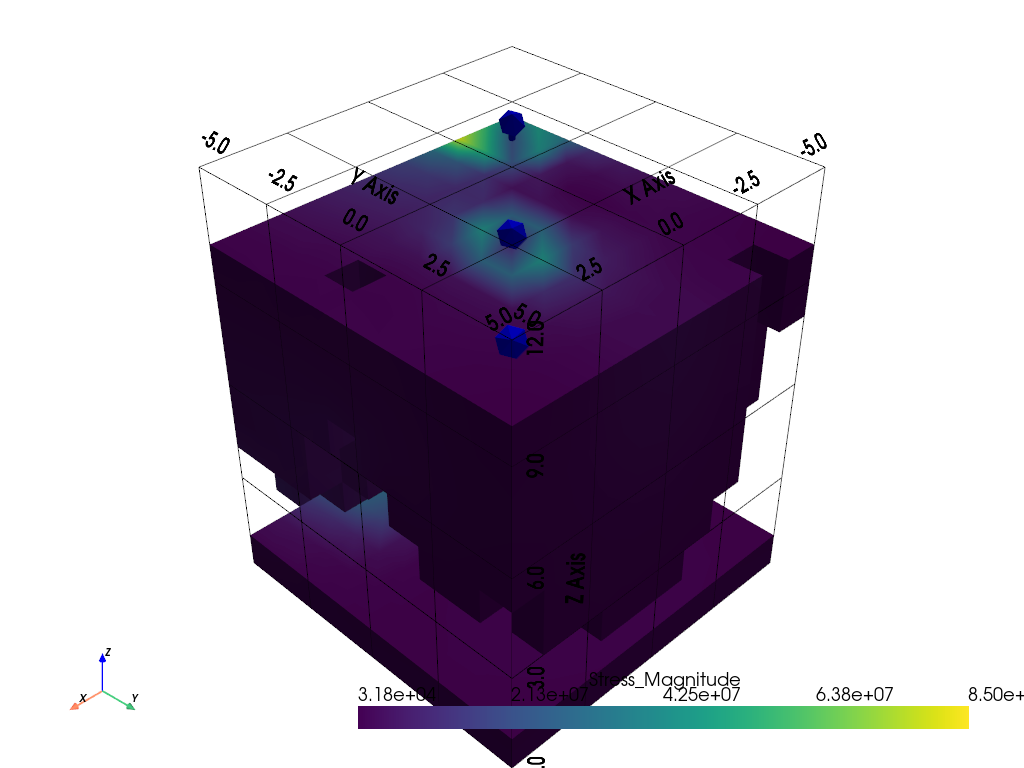

In [79]:
def fields_plot_3d(
    nodes: NDArray[np.float64], 
    els: NDArray[np.int_], 
    loads: NDArray[np.float64], 
    idx_BC: NDArray[np.float64], 
    nnodes: int = 8,
    data_type: str = 'stress',
    show_loads: bool = False,
    arrow_scale: float = 1.0,
    arrow_color: str = "red",
    cmap: str = "viridis",
    show_axes: bool = True,
    show_bounds: bool = True,
    show_edges: bool = True
) -> None:
    """
    Plots a 3D finite element mesh with stress/strain data using PyVista. 
    Optionally shows load arrows and allows customization of plot properties.

    Parameters
    ----------
    nodes : NDArray[np.float64]
        Nodal data array of shape (Nnodes, 4), where columns are [node_id, x, y, z].
    els : NDArray[np.int_]
        Element connectivity array of shape (Nelems, 3 + nnodes). 
        Typically columns might be [elem_id, mat_id, sec_id, node1, node2, ..., nodeN].
    loads : NDArray[np.float64]
        Load array of shape (Nloads, 4): [node_num, Fx, Fy, Fz].
    idx_BC : NDArray[np.float64]
        Indices or flags for boundary conditions (not used in this example, but included for completeness).
    nnodes : int, optional
        Number of nodes per element (4 or 8). Default is 8.
    data_type : str, optional
        Either 'stress' or 'strain'. Default is 'stress'.
    show_loads : bool, optional
        Whether to show load arrows. Default is False.
    arrow_scale : float, optional
        Scale factor for load arrows. Default is 1.0.
    arrow_color : str, optional
        Color for the load arrows. Default is 'red'.
    cmap : str, optional
        Colormap for the scalar field. Default is 'viridis'.
    show_axes : bool, optional
        Whether to show the coordinate axes. Default is True.
    show_bounds : bool, optional
        Whether to show bounding box around the model. Default is True.
    show_edges : bool, optional
        Whether to show mesh edges. Default is True.
    """

    assert nnodes in [4, 8], "nnodes must be either 4 or 8 (3D elements)"
    assert data_type in ['stress', 'strain'], "data_type must be either 'stress' or 'strain'"

    # 1. Extract nodal coordinates
    points = nodes[:, 1:4]  # x, y, z coordinates

    # 2. Construct the connectivity array for UnstructuredGrid
    #    Typically els has shape (Nelems, 3 + nnodes): 
    #       [elem_id, material_id, section_id, node1, node2, ..., nodeN].
    #    The last nnodes columns are the node IDs for each element.
    element_connectivity = els[:, 3:].astype(int)  # node indices for each element
    num_elems = element_connectivity.shape[0]

    # PyVista expects a "cells" 1D array in the format:
    #    [nnodes, n1, n2, ..., nnodes, n1, n2, ...]
    # where nnodes is repeated before each connectivity list.
    cells = []
    for i in range(num_elems):
        cells.append(nnodes)
        cells.extend(element_connectivity[i])
    cells = np.array(cells, dtype=int)

    # 3. Define the cell types
    n_type = 12 if nnodes == 8 else 10
    cell_types = np.full(num_elems, n_type, dtype=np.uint8)

    # 4. Create the UnstructuredGrid
    grid = pv.UnstructuredGrid(cells, cell_types, points)

    # 5. Attach either stress or strain data as point data

    if data_type == 'stress':
        S_magnitude = np.linalg.norm(S_nodes, axis=1)
        grid.point_data["Stress_Magnitude"] = S_magnitude
        scalars = "Stress_Magnitude"
    else:
        E_magnitude = np.linalg.norm(E_nodes, axis=1)
        grid.point_data["Strain_Magnitude"] = E_magnitude
        scalars = "Strain_Magnitude"

    plotter = pv.Plotter()

    # 6. Add the FE mesh to the plot
    plotter.add_mesh(
        grid, 
        scalars=scalars, 
        cmap=cmap, 
        show_edges=show_edges
    )

    # 7. Optionally, show load vectors as arrows
    loads[:, 1:] = loads[:, 1:] / loads[:, 1:].max(axis=1)
    if show_loads and loads is not None and loads.size > 0:
        # Collect load vectors and their corresponding node coordinates
        load_points = []
        load_vectors = []
        for row in loads:
            node_num, Fx, Fy, Fz = row
            load_points.append(points[int(node_num)])
            load_vectors.append([Fx, Fy, Fz])

        load_points = np.array(load_points, dtype=np.float64)
        load_vectors = np.array(load_vectors, dtype=np.float64)

        if len(load_points) > 0:
            # Create a PyVista PolyData from these points
            load_polydata = pv.PolyData(load_points)
            load_polydata["LoadVectors"] = load_vectors

            # Use glyph to create arrow objects at each loaded node
            arrows = load_polydata.glyph(
                orient="LoadVectors",       # which array to orient arrows
                scale="LoadVectors",        # which array to scale arrows
                factor=arrow_scale          # global scale factor
            )
            plotter.add_mesh(arrows, color=arrow_color, name='LoadArrows')

    # 8. Show/hide axes and bounds
    if show_axes:
        plotter.add_axes()

    if show_bounds:
        plotter.show_bounds(grid="front")

    # 9. Show the final plot
    plotter.show()
fields_plot_3d(nodes, els, loads, idx_BC, nnodes=8, data_type='stress', show_loads=True, arrow_scale=2.0, arrow_color="blue", cmap="viridis", show_axes=True, show_bounds=True, show_edges=False)